In [1]:
!pip -q install yfinance pandas numpy scikit-learn matplotlib ta

  Preparing metadata (setup.py) ... done


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)

TICKER = "AAPL"
PERIOD = "max"

In [3]:
df = yf.download(TICKER, period=PERIOD, auto_adjust=True)

if isinstance(df.columns, pd.MultiIndex):
    df = df.xs(TICKER, axis=1, level=1)
    df.columns.name = None

df = df.dropna()

print("Columns:", df.columns.tolist())
print("Shape  :", df.shape)
df.head()

[*********************100%***********************]  1 of 1 completed

Columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Shape  : (11274, 5)


,Close,High,Low,Open,Volume
Date,,,,,
1980-12-12,0.098485,0.098913,0.098485,0.098485,469033600
1980-12-15,0.093347,0.093775,0.093347,0.093775,175884800
1980-12-16,0.086495,0.086924,0.086495,0.086924,105728000
1980-12-17,0.088636,0.089064,0.088636,0.088636,86441600
1980-12-18,0.091206,0.091634,0.091206,0.091206,73449600


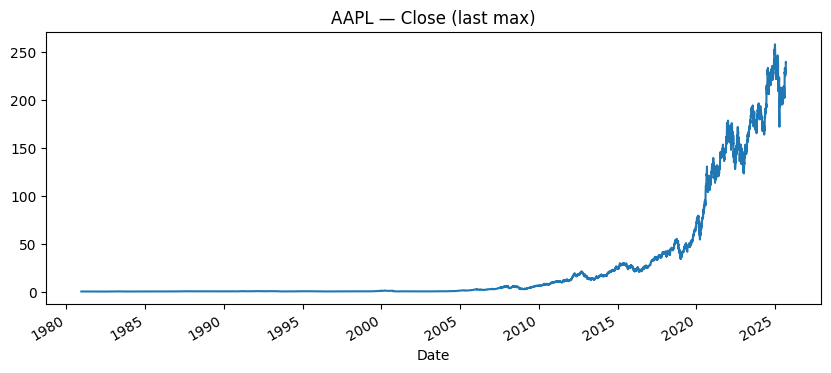

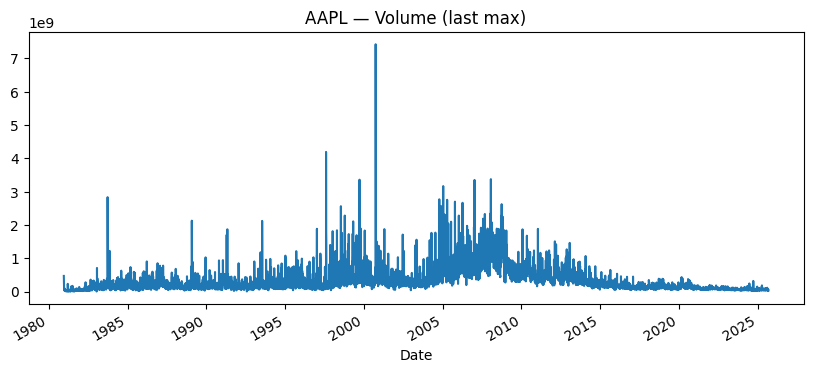

In [4]:
df["Close"].plot(title=f"{TICKER} — Close (last {PERIOD})")
plt.show()

df["Volume"].plot(title=f"{TICKER} — Volume (last {PERIOD})")
plt.show()

In [5]:
data = df.copy()

data["y_dir"] = (data["Close"].shift(-1) > data["Close"]).astype(int)

data = data.dropna()

print("Rows after target:", len(data))
print("Class balance (0=down/flat, 1=up):")
print(data["y_dir"].value_counts(normalize=True).round(3))
data.tail()

Rows after target: 11274
Class balance (0=down/flat, 1=up):
y_dir
0    0.501
1    0.499
Name: proportion, dtype: float64


,Close,High,Low,Open,Volume,y_dir
Date,,,,,,
2025-08-29,232.139999,233.380005,231.369995,232.509995,39418400,0
2025-09-02,229.720001,230.850006,226.970001,229.250000,44075600,1
2025-09-03,238.470001,238.850006,234.360001,237.210007,66427800,1
2025-09-04,239.779999,239.899994,236.740005,238.449997,47504000,0
2025-09-05,239.190002,241.320007,238.490097,239.990005,28921768,0


In [6]:
FEATURES = ["Open", "High", "Low", "Close", "Volume"]
X = data[FEATURES].values
y = data["y_dir"].values

n = len(data)
cut = int(n * 0.8)

X_train, X_test = X[:cut], X[cut:]
y_train, y_test = y[:cut], y[cut:]

print("Train shape:", X_train.shape, y_train.shape)
print("Test  shape:", X_test.shape, y_test.shape)

Train shape: (9019, 5) (9019,)
Test  shape: (2255, 5) (2255,)


Logistic Regression — Test Metrics
Accuracy: 0.536   F1: 0.698   ROC-AUC: 0.488

Detailed classification report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000      1046
           1      0.536     1.000     0.698      1209

    accuracy                          0.536      2255
   macro avg      0.268     0.500     0.349      2255
weighted avg      0.287     0.536     0.374      2255


Last 5 (P(up), pred, true):
 [[0.804 1.    0.   ]
 [0.8   1.    1.   ]
 [0.809 1.    1.   ]
 [0.81  1.    0.   ]
 [0.811 1.    0.   ]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


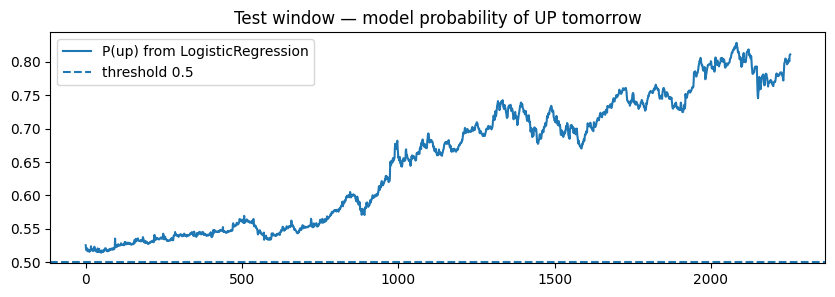

In [ ]:
# 1. Logistic Regression 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import numpy as np
import matplotlib.pyplot as plt


logreg_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, random_state=42))
])

logreg_pipe.fit(X_train, y_train)

proba_up = logreg_pipe.predict_proba(X_test)[:, 1]
pred_dir = (proba_up >= 0.5).astype(int)

acc = accuracy_score(y_test, pred_dir)
f1  = f1_score(y_test, pred_dir)
auc = roc_auc_score(y_test, proba_up)

print(f"Logistic Regression — Test Metrics")
print(f"Accuracy: {acc:.3f}   F1: {f1:.3f}   ROC-AUC: {auc:.3f}\n")
print("Detailed classification report:\n", classification_report(y_test, pred_dir, digits=3))

peek = np.column_stack([proba_up[-5:], pred_dir[-5:], y_test[-5:]])
print("\nLast 5 (P(up), pred, true):\n", np.round(peek, 3))

plt.figure(figsize=(10,3))
plt.plot(proba_up, label="P(up) from LogisticRegression")
plt.axhline(0.5, linestyle="--", label="threshold 0.5")
plt.title("Test window — model probability of UP tomorrow")
plt.legend(); plt.show()

Random Forest — Test Metrics
Accuracy: 0.466   F1: 0.026   ROC-AUC: 0.495

Classification report:
               precision    recall  f1-score   support

           0      0.465     0.989     0.632      1046
           1      0.593     0.013     0.026      1209

    accuracy                          0.466      2255
   macro avg      0.529     0.501     0.329      2255
weighted avg      0.533     0.466     0.307      2255


Confusion Matrix:
               Pred DOWN(0)  Pred UP(1)
True DOWN(0)          1035          11
True UP(1)            1193          16

Last 5 (P(up), pred, true):
 [[0.135 0.    0.   ]
 [0.136 0.    1.   ]
 [0.124 0.    1.   ]
 [0.133 0.    0.   ]
 [0.136 0.    0.   ]]


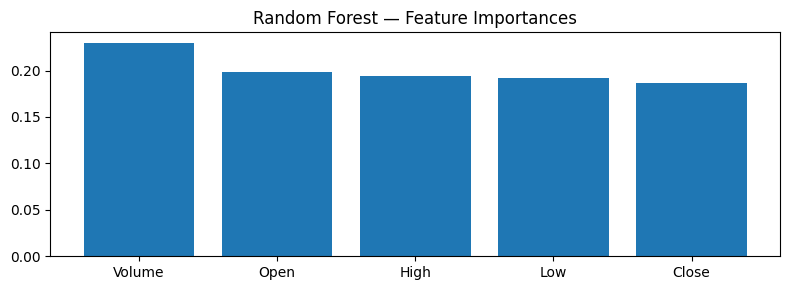

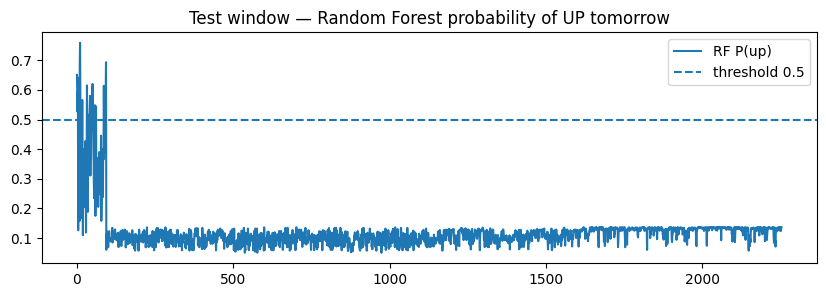

In [ ]:
# 2. Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)

proba_up_rf = rf.predict_proba(X_test)[:, 1]
pred_dir_rf = (proba_up_rf >= 0.5).astype(int)

acc_rf = accuracy_score(y_test, pred_dir_rf)
f1_rf  = f1_score(y_test, pred_dir_rf)
auc_rf = roc_auc_score(y_test, proba_up_rf)

print("Random Forest — Test Metrics")
print(f"Accuracy: {acc_rf:.3f}   F1: {f1_rf:.3f}   ROC-AUC: {auc_rf:.3f}\n")
print("Classification report:\n", classification_report(y_test, pred_dir_rf, digits=3))

cm = confusion_matrix(y_test, pred_dir_rf)
cm_df = pd.DataFrame(cm, index=["True DOWN(0)", "True UP(1)"], columns=["Pred DOWN(0)", "Pred UP(1)"])
print("\nConfusion Matrix:\n", cm_df)

peek = np.column_stack([proba_up_rf[-5:], pred_dir_rf[-5:], y_test[-5:]])
print("\nLast 5 (P(up), pred, true):\n", np.round(peek, 3))

plt.figure(figsize=(8,3))
importances = rf.feature_importances_
order = np.argsort(importances)[::-1]
plt.bar(range(len(importances)), importances[order])
plt.xticks(range(len(importances)), [FEATURES[i] for i in order], rotation=0)
plt.title("Random Forest — Feature Importances")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(proba_up_rf, label="RF P(up)")
plt.axhline(0.5, linestyle="--", label="threshold 0.5")
plt.title("Test window — Random Forest probability of UP tomorrow")
plt.legend(); plt.show()

In [9]:
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands

data = df.copy()


data["ret_1"] = data["Close"].pct_change()

data["sma_5"]  = data["Close"].rolling(5).mean()
data["sma_10"] = data["Close"].rolling(10).mean()
data["sma_20"] = data["Close"].rolling(20).mean()

data["volatility_10"] = data["Close"].pct_change().rolling(10).std()

rsi = RSIIndicator(data["Close"], window=14)
data["rsi_14"] = rsi.rsi()

macd = MACD(data["Close"], window_slow=26, window_fast=12, window_sign=9)
data["macd"]        = macd.macd()
data["macd_signal"] = macd.macd_signal()
data["macd_hist"]   = macd.macd_diff()

bb = BollingerBands(data["Close"], window=20, window_dev=2)
data["bb_high"] = bb.bollinger_hband()
data["bb_low"]  = bb.bollinger_lband()

data["y_dir"] = (data["Close"].shift(-1) > data["Close"]).astype(int)

data = data.dropna()

FEATURES = ["ret_1", "sma_5", "sma_10", "sma_20", "volatility_10",
            "rsi_14", "macd", "macd_signal", "macd_hist", "bb_high", "bb_low"]

X = data[FEATURES].values
y = data["y_dir"].values

n = len(data)
cut = int(n * 0.8)
X_train, X_test = X[:cut], X[cut:]
y_train, y_test = y[:cut], y[cut:]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (8992, 11) Test shape: (2249, 11)


Ridge Regression — Test Metrics
RMSE: 3.488
MAE : 2.216

Last 5 (predicted, true):
 [[229.65 232.14]
 [230.92 229.72]
 [231.73 238.47]
 [234.11 239.78]
 [236.14 239.19]]


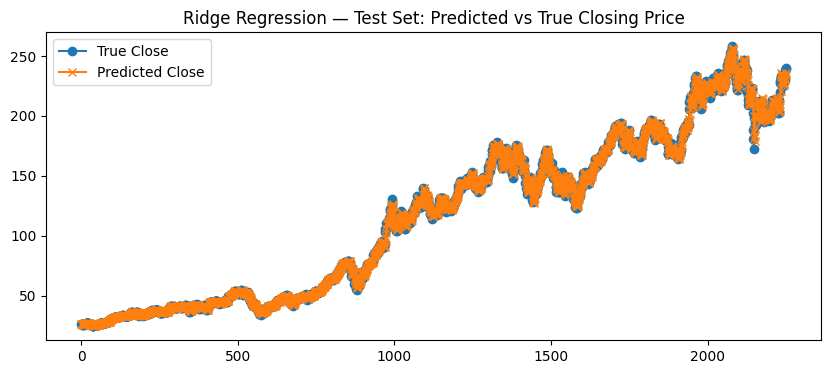

In [11]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

data_reg = df.copy()

data_reg["y_next_close"] = data_reg["Close"].shift(-1)

data_reg["ret_1"] = data_reg["Close"].pct_change()
data_reg["sma_5"]  = data_reg["Close"].rolling(5).mean()
data_reg["sma_10"] = data_reg["Close"].rolling(10).mean()
data_reg["sma_20"] = data_reg["Close"].rolling(20).mean()
data_reg["volatility_10"] = data_reg["Close"].pct_change().rolling(10).std()

data_reg = data_reg.dropna()

FEATURES_REG = ["ret_1", "sma_5", "sma_10", "sma_20", "volatility_10"]
X = data_reg[FEATURES_REG].values
y = data_reg["y_next_close"].values

n = len(data_reg)
cut = int(n*0.8)
X_train, X_test = X[:cut], X[cut:]
y_train, y_test = y[:cut], y[cut:]

# 3.Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)

print("Ridge Regression — Test Metrics")
print(f"RMSE: {rmse:.3f}")
print(f"MAE : {mae:.3f}")

peek = np.column_stack([y_pred[-5:], y_test[-5:]])
print("\nLast 5 (predicted, true):\n", np.round(peek, 2))

plt.figure(figsize=(10,4))
plt.plot(y_test, label="True Close", marker="o")
plt.plot(y_pred, label="Predicted Close", marker="x")
plt.title("Ridge Regression — Test Set: Predicted vs True Closing Price")
plt.legend(); plt.show()

In [12]:
!pip install xgboost

In [13]:
import numpy as np
import pandas as pd
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands


data_cls = df.copy()

data_cls["ret_1"] = data_cls["Close"].pct_change()
data_cls["sma_5"]  = data_cls["Close"].rolling(5).mean()
data_cls["sma_10"] = data_cls["Close"].rolling(10).mean()
data_cls["sma_20"] = data_cls["Close"].rolling(20).mean()
data_cls["volatility_10"] = data_cls["Close"].pct_change().rolling(10).std()

rsi = RSIIndicator(data_cls["Close"], window=14)
data_cls["rsi_14"] = rsi.rsi()

macd = MACD(data_cls["Close"], window_slow=26, window_fast=12, window_sign=9)
data_cls["macd"]        = macd.macd()
data_cls["macd_signal"] = macd.macd_signal()
data_cls["macd_hist"]   = macd.macd_diff()

bb = BollingerBands(data_cls["Close"], window=20, window_dev=2)
data_cls["bb_high"] = bb.bollinger_hband()
data_cls["bb_low"]  = bb.bollinger_lband()

data_cls["y_dir"] = (data_cls["Close"].shift(-1) > data_cls["Close"]).astype(int)

data_cls = data_cls.dropna()

FEATURES = [
    "ret_1", "sma_5", "sma_10", "sma_20", "volatility_10",
    "rsi_14", "macd", "macd_signal", "macd_hist", "bb_high", "bb_low"
]

Xc = data_cls[FEATURES].values
yc = data_cls["y_dir"].astype(int).values

n = len(data_cls)
cut = int(n * 0.8)
Xc_train, Xc_test = Xc[:cut], Xc[cut:]
yc_train, yc_test = yc[:cut], yc[cut:]

print("Classes in yc_train:", np.unique(yc_train))
print("Shapes -> Train:", Xc_train.shape, " Test:", Xc_test.shape)

Classes in yc_train: [0 1]
Shapes -> Train: (8992, 11)  Test: (2249, 11)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from xgboost import XGBClassifier

def evaluate(name, proba, y_true):
    pred = (proba >= 0.5).astype(int)
    acc = accuracy_score(y_true, pred)
    f1  = f1_score(y_true, pred)
    auc = roc_auc_score(y_true, proba)
    print(f"{name:20s}  Acc: {acc:.3f}  F1: {f1:.3f}  AUC: {auc:.3f}")
    return acc, f1, auc

# 1) Logistic Regression
logreg = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, random_state=42))
])
logreg.fit(Xc_train, yc_train)
proba_log = logreg.predict_proba(Xc_test)[:, 1]

# 2) Random Forest
rf = RandomForestClassifier(n_estimators=400, min_samples_leaf=2, random_state=42, n_jobs=-1)
rf.fit(Xc_train, yc_train)
proba_rf = rf.predict_proba(Xc_test)[:, 1]

# 3) XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="logloss",
    objective="binary:logistic",
    random_state=42
)
xgb.fit(Xc_train, yc_train)
proba_xgb = xgb.predict_proba(Xc_test)[:, 1]

print("=== Model comparison (classification) ===")
evaluate("LogisticRegression", proba_log, yc_test)
evaluate("RandomForest",      proba_rf,  yc_test)
evaluate("XGBoost",           proba_xgb, yc_test)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:42:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Model comparison (classification) ===
LogisticRegression    Acc: 0.535  F1: 0.696  AUC: 0.489
RandomForest          Acc: 0.483  F1: 0.376  AUC: 0.498
XGBoost               Acc: 0.472  F1: 0.293  AUC: 0.501


(0.47176522899066253, 0.29285714285714287, np.float64(0.500515626217506))